# Deep: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_copom = pd.read_csv('df_copom_label.csv')

In [3]:
df_copom.head()

,Date,Selic,Meeting_Number,Decision,Decision_txt,label_hawk_dove,label_next_meet,Text,Type
0,2006/03/08,16.50,117.0,-0.75,decrease,dovish,decrease,"In the March Meeting, the Banco Central do Br...",Statement
1,2006/04/19,15.75,118.0,-0.75,decrease,dovish,decrease,"In the April Meeting, the Monetary Policy Com...",Statement
2,2006/05/31,15.25,119.0,-0.50,decrease,dovish,decrease,"In the May Meeting, the Monetary Policy Commi...",Statement
3,2006/07/19,14.75,120.0,-0.50,decrease,dovish,decrease,"In the July Meeting, the Copom unanimously de...",Statement
4,2006/08/30,14.25,121.0,-0.50,decrease,dovish,decrease,"In the August Meeting, the Copom unanimously ...",Statement


In [4]:
df_copom.iloc[29]

Date                                                      2009/10/21
Selic                                                           8.75
Meeting_Number                                                   146
Decision                                                           0
Decision_txt                                                 mantain
label_hawk_dove                                              neutral
label_next_meet                                              mantain
Text                  \tBrasília - In light of inflation prospect...
Type                                                       Statement
Name: 29, dtype: object

In [5]:
df_copom.shape

(159, 9)

### Split test and train

In [6]:
from sklearn.model_selection import train_test_split

C:\Users\ftrav\anaconda3\envs\pytorchenv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [7]:
X = df_copom.copy()
y = df_copom['label_hawk_dove']

In [8]:
#Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
texts = X_train['Text'].tolist()
labels = y_train.tolist()

In [10]:
len(texts)

143

In [11]:
len(labels)

143

In [12]:
seq_len = 512 # number of the tokens tokenizer will create
num_samples = len (texts)
num_samples, seq_len

(143, 512)

#### Convert labels to one-hot encoded vectors

In [13]:
label_classes = list(set(labels))
num_classes = len(label_classes)

label_to_index = {label: index for index, label in enumerate(label_classes)}
index_to_label = {index: label for label, index in label_to_index.items()}

labels_encoded = np.array([label_to_index[label] for label in labels])
labels = np.eye(num_classes)[labels_encoded]
labels[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [14]:
len(labels)

143

## ChatCPG

In [15]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenize the text documents
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to have the same length
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Convert labels to numpy array
numerical_labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, numerical_labels, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
4/4 [==============================] - 70s 18s/step - loss: 1.0975 - accuracy: 0.3860 - val_loss: 1.0910 - val_accuracy: 0.4483
Epoch 2/20
4/4 [==============================] - 70s 18s/step - loss: 1.0875 - accuracy: 0.4474 - val_loss: 1.0824 - val_accuracy: 0.4483
Epoch 3/20
4/4 [==============================] - 72s 19s/step - loss: 1.0800 - accuracy: 0.4912 - val_loss: 1.0739 - val_accuracy: 0.6207
Epoch 4/20
4/4 [==============================] - 71s 18s/step - loss: 1.0624 - accuracy: 0.5175 - val_loss: 1.0589 - val_accuracy: 0.6552
Epoch 5/20
4/4 [==============================] - 73s 19s/step - loss: 1.0352 - accuracy: 0.5000 - val_loss: 1.0295 - val_accuracy: 0.4828
Epoch 6/20
4/4 [==============================] - 71s 18s/step - loss: 1.0275 - accuracy: 0.4825 - val_loss: 0.9913 - val_accuracy: 0.5172
Epoch 7/20
4/4 [==============================] - 74s 19s/step - loss: 0.9944 - accuracy: 0.5263 - val_loss: 0.9372 - val_accuracy: 0.5862
Epoch 8/20
4/4 [===========

In [17]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

1/1 [==============================] - 1s 826ms/step - loss: 0.9634 - accuracy: 0.4483
Test loss: 0.96344393491745
Test accuracy: 0.4482758641242981


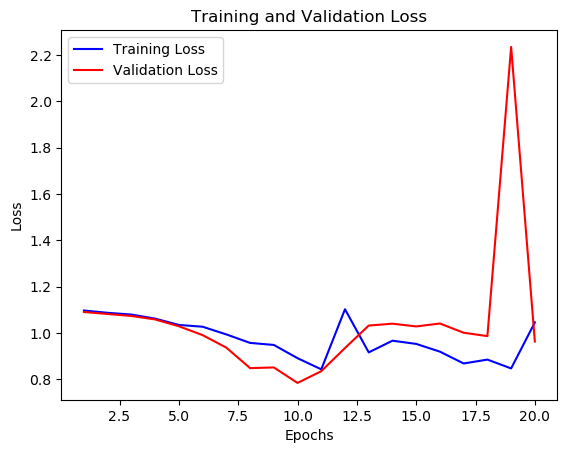

In [18]:
# Extract loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
new_texts = X_test['Text'].to_list()

In [20]:
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)

In [21]:
predictions = model.predict(new_padded_sequences)

1/1 [==============================] - 1s 854ms/step


In [22]:
X_test['Sentiment'] = np.argmax(predictions, axis=1)

C:\Users\ftrav\anaconda3\envs\pytorchenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
X_test

,Date,Selic,Meeting_Number,Decision,Decision_txt,label_hawk_dove,label_next_meet,Text,Type,Sentiment
78,2016/03/02,14.25,197.0,0.00,mantain,neutral,mantain,The Copom released the following note to the ...,Statement,0
155,2023/03/22,13.75,253.0,0.00,mantain,neutral,mantain,A) Update of economic outlook and Copom’s scen...,Minutes,2
128,2021/06/16,4.25,239.0,0.75,increase,hawkish,increase,A) Update of economic outlook and Copom’s base...,Minutes,2
55,2013/04/17,7.50,174.0,0.25,increase,hawkish,increase,The Copom released the following note to the ...,Statement,0
94,2018/03/21,6.50,213.0,-0.25,decrease,dovish,mantain,The Copom unanimously decided to reduce the Se...,Statement,1
29,2009/10/21,8.75,146.0,0.00,mantain,neutral,mantain,\tBrasília - In light of inflation prospect...,Statement,0
147,2022/09/21,13.75,249.0,0.00,mantain,dovish,mantain,A) Update of economic outlook and Copom’s scen...,Minutes,2
51,2012/10/10,7.25,170.0,-0.25,decrease,dovish,mantain,The Copom released the following note to the ...,Statement,0
98,2018/09/19,6.50,217.0,0.00,mantain,neutral,mantain,​The Copom unanimously decided to maintain the...,Statement,2
141,2022/05/04,12.75,246.0,1.00,increase,hawkish,increase,"​In its 246th meeting, the Copom unanimously d...",Statement,0
